# Desafío Data Scientist NeuralWorks

## Código inicial
Importamos algunas librerías necesarias.


In [5]:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
from ydata_profiling import ProfileReport
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

## 1. Análisis exploratorio preliminar

Para resolver esta primera parte haremos un análisis exploratorio de los datos, haremos una limpieza básica en caso de ser necesario, veremos algunas métricas como la correlación, entre otras cosas.

In [6]:
#Cargamos y revisamos el dataset
df = pd.read_csv('dataset_SCL.csv')
df.sample(10)

C:\Users\Miguel\AppData\Local\Temp\ipykernel_5804\3706357585.py:2: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dataset_SCL.csv')


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
26227,2017-05-16 11:25:00,434,SCEL,SAME,LAN,2017-05-16 11:42:00,434,SCEL,SAME,LAN,16,5,2017,Martes,I,Grupo LATAM,Santiago,Mendoza
36876,2017-07-01 07:25:00,404,SCEL,SUMU,LAN,2017-07-01 07:26:00,404,SCEL,SUMU,LAN,1,7,2017,Sabado,I,Grupo LATAM,Santiago,Montevideo
32952,2017-07-17 02:12:00,174,SCEL,MPTO,CMP,2017-07-17 02:05:00,174,SCEL,MPTO,CMP,17,7,2017,Lunes,I,Copa Air,Santiago,Ciudad de Panama
57025,2017-11-22 12:35:00,13,SCEL,SCTE,SKU,2017-11-22 12:42:00,13,SCEL,SCTE,SKU,22,11,2017,Miercoles,N,Sky Airline,Santiago,Puerto Montt
7172,2017-02-19 14:15:00,9651,SCEL,SBGL,TAM,2017-02-19 14:12:00,9651,SCEL,SBGL,TAM,19,2,2017,Domingo,I,Grupo LATAM,Santiago,Rio de Janeiro
3066,2017-01-09 04:40:00,160,SCEL,SCDA,LAN,2017-01-09 04:34:00,160,SCEL,SCDA,LAN,9,1,2017,Lunes,N,Grupo LATAM,Santiago,Iquique
33250,2017-07-12 06:14:00,624,SCEL,SPJC,AVA,2017-07-12 06:11:00,624,SCEL,SPJC,LRC,12,7,2017,Miercoles,I,Avianca,Santiago,Lima
46203,2017-09-08 07:35:00,501,SCEL,SAEZ,SKU,2017-09-08 07:46:00,501,SCEL,SAEZ,SKU,8,9,2017,Viernes,I,Sky Airline,Santiago,Buenos Aires
13723,2017-03-04 21:10:00,503,SCEL,SAEZ,SKU,2017-03-04 21:17:00,503,SCEL,SAEZ,SKU,4,3,2017,Sabado,I,Sky Airline,Santiago,Buenos Aires
57745,2017-11-16 07:30:00,174,SCEL,SCDA,SKU,2017-11-16 07:36:00,174,SCEL,SCDA,SKU,16,11,2017,Jueves,N,Sky Airline,Santiago,Iquique


In [7]:
# Ocupamos info para ver los datos no-nulos y los tipos de cada variable
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


Notamos dos cosas enseguida:
1.   Hay un valor nulo en la columna Vlo-O al ser la única columna con una cuenta de 68205 datos no nulos.

2.   Las variables Vlo-O y Vlo-I al parecer contienen componentes no numéricas en algunas entradas porque de otro modo no se habrían importado como tipo objeto, eliminaremos esos datos.

3.   Hay varias variables con texto, por lo que usaremos ydata_profiling para el siguiente análisis exploratorio ya que nos permite operar en este tipo de datos para extraer por ejemplo correlaciones.



In [8]:
df['Vlo-I'] = pd.to_numeric(df['Vlo-I'], errors='coerce')
df['Vlo-O'] = pd.to_numeric(df['Vlo-O'], errors='coerce')
df.dropna(inplace=True)

Pasaremos las fechas de formato texto a formato datetime para poder operar sobre ellas a futuro, y verificaremos que no hayan problemas en la conversión.

In [9]:
df['Fecha-O'] = pd.to_datetime(df['Fecha-O'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df['Fecha-I'] = pd.to_datetime(df['Fecha-I'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
#Verificamos si hubo alguna fecha con error
print(f'Al transformar a formato datetime se encontraron {df["Fecha-O"].isnull().sum()} con error en Fecha-O y {df["Fecha-I"].isnull().sum()} con error en Fecha-I')

Al transformar a formato datetime se encontraron 0 con error en Fecha-O y 0 con error en Fecha-I


Ahora utilizaremos la librería [ydata_profiling](https://ydata-profiling.ydata.ai/docs/master/index.html), una herramienta para eploración preliminar de datos o Exploratory Data Analysis (EDA).
Haremos un reporte preliminar con la data el cual estará disponible en el archivo [AnalisisExploratorio.html](AnalisisExploratorio.html) incluido en este repositorio.

La principal utilidad de esta herramienta es que nos da métricas de correlación entre variables incluso si estas no son numéricas además de entregar algunos comentarios en cuanto al balance de cada variable.

In [10]:
profile = ProfileReport(df, title="Profiling Report")

In [11]:
profile.to_file("AnalisisExploratorio.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

De este reporte se extrae la matriz de correlación de las variables a estudiar la cual se visualiza a continuación.

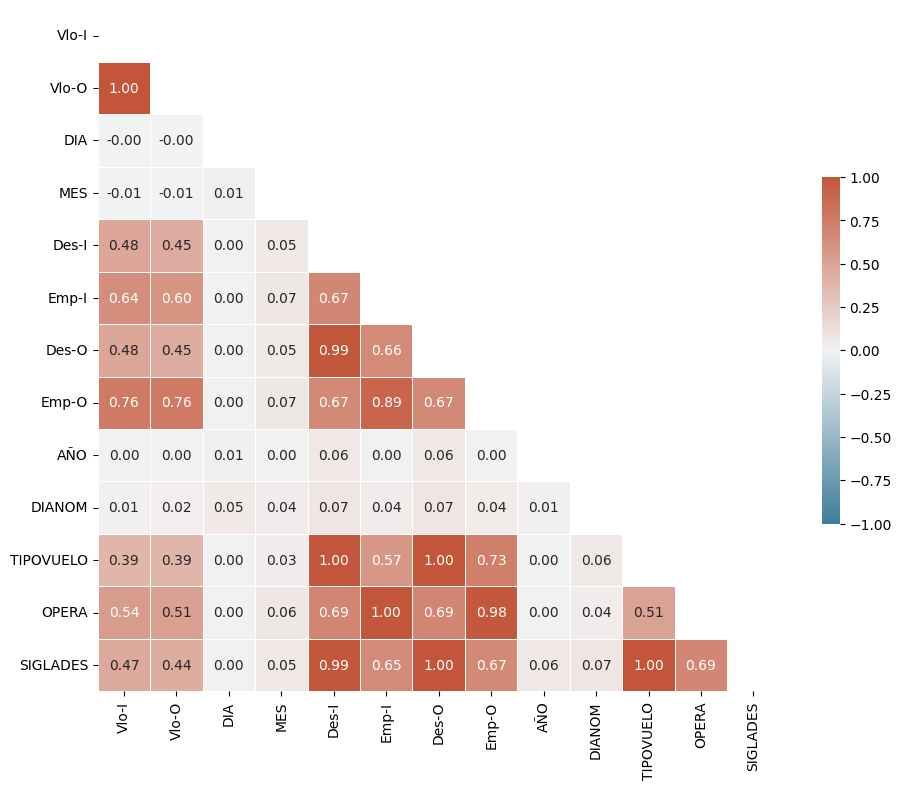

In [12]:
corr = np.loadtxt('Corr_Matrix.txt', delimiter=',')
labels = ["Vlo-I","Vlo-O","DIA","MES","Des-I","Emp-I","Des-O","Emp-O","AÑO","DIANOM","TIPOVUELO","OPERA","SIGLADES"]
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            xticklabels=labels, yticklabels=labels, annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

**Algunas observaciones importantes que se pueden extraer del reporte preliminar:**



1. Hay variables con **valores constantes**:

  *   Ori-O y Ori-I tienen constante el valor "SCEL", lo que tiene sentido pues son datos del aeropuerto de Chile.

  *   SIGLAORI tiene el valor constante "Santiago", que sigue la misma lógica anterior.

2. Hay varios casos de **alta correlación** entre variables:

  *  Vlo-O y Vlo-I tienen una correlación del 99%

  *  Emp-I con OPERA tiene correlación de 1. La primera variable corresponde a la sigla de la compañía en la segunda variable. Emp-O también tiene muy alta correlación con estas dos variables pero en menor medida.

  * Las variables Des-I, Des-O, SIGLADES y TIPOVUELO están fuertemente correlacionadas con valores del superiores al 99% y en varios casos al 100%. Esto obviamente tiene relación con que los vuelos tiene destinos predeterminados con anterioridad y estos no cambian, los vuelos nacionales no pueden ocurrir en ciudades internacionales y viceversa o hay vuelos que solo los hace una aerolínea en particular.

3. La variable OPERA (y Emp-I) tiene un fuerte desbalanceo, la mayoría de los datos provienen de LATAM y Sky Airline. Lo mismo pasa con la variable AÑO, tiene todas sus entradas en el año 2017 salvo 2 en el año 2018.

**Con respecto a esta exploración preliminar para mejorar un modelo de predicción sería prudente :**

  *   Eliminar las variables constantes: Ori-O, Ori-I y SIGLAORI.
  *   Eliminar Vlo-O, convervar Vlo-I
  *   Eliminar OPERA, conservar Emp-I.
  *   Eliminar TIPOVUELO, SIGLADES y OPERA, conservar Des-I y Des-O.
  *   Eliminar AÑO.

Si bien estas variables no se utilizarían para entrenar un modelo, sí podrían ser de mucha utilidad para hacer visualizaciones por compañía o tipo de vuelo.

El supuesto de esto sería que a futuro se utilizará este modelo solo para data de Chile, si se quisiera integrar data de otros aeropuertos habría que reintegrar estas variables eliminadas y hacer otro análisis exploratorio.



## 2. Creación de variables 

Operamos sobre la fecha y creamos las variables solicitadas.

In [13]:
""" Por claridad podemos recordar que: - Diciembre = 12
                                       - Febrero = 2
                                       - Marzo = 3
                                       - Julio = 7
                                       - Septiembre = 9
"""
df['temporada_alta'] = df['Fecha-I'].apply(lambda fecha: 1 if (((fecha.month<=2) or (fecha.month==3 and fecha.day<=3) | (fecha.month==12 and fecha.day>=15))
                                                              or (fecha.month==7 and (fecha.day>=15 and fecha.day<=31))
                                                              or (fecha.month==9 and (fecha.day>=11 and fecha.day<=30)))
                                                           else 0)
df['dif_min'] = (df['Fecha-O']-df['Fecha-I'])
df['dif_min'] = df['dif_min'].dt.total_seconds()
df['atraso_15'] = df['dif_min'].apply(lambda tiempo: 1 if tiempo > 15*60
                                                       else 0)
df['periodo_dia'] = df['Fecha-I'].apply(lambda fecha: 'mañana' if (fecha.hour >= 5 and fecha.hour < 12)
                                                               else ('tarde' if (fecha.hour >= 12 and fecha.hour < 19)
                                                                    else 'noche'))

In [14]:
# Guardamos las variables generadas en el archivo "synthetic_features.csv"
aux= df[['dif_min','temporada_alta','periodo_dia','atraso_15']]
aux.to_csv('synthetic_features.csv', index=False)

## 3. Tasas de atraso

Como base vamos a calcular la tasa de atraso de todo el dataset y haremos un gráfico de torta con esta proporción.
Además veremos cómo se distribuyen los atrasos a lo largo del año.

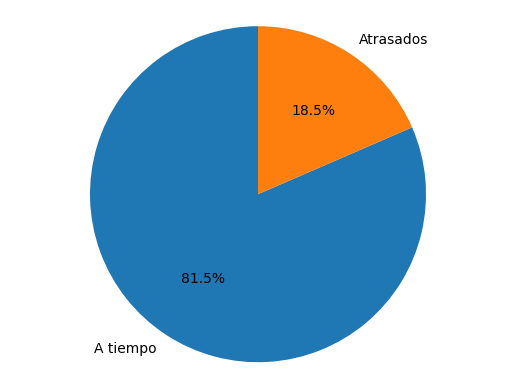

C:\Users\Miguel\AppData\Local\Temp\ipykernel_5804\217923440.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_aux = df_aux.groupby([df_aux['Fecha-I'].dt.date]).sum()


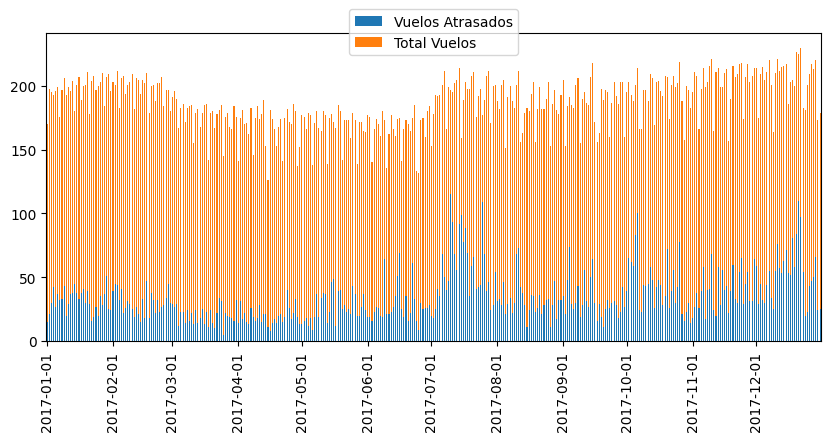

In [15]:
#Veamos la proporción de vuelos atrasados y a tiempo
sizes = df['atraso_15'].value_counts()
nombres = ['A tiempo', 'Atrasados']
fig, ax = plt.subplots()
ax.pie(sizes, labels=nombres, autopct='%1.1f%%', startangle=90)
ax.axis('equal')
plt.show()

fig = plt.figure(figsize=(10,4))
ax = plt.axes()
df_aux = df[['Fecha-I','atraso_15']].copy(deep=True)
df_aux['total_vuelos'] = 1
df_aux = df_aux.groupby([df_aux['Fecha-I'].dt.date]).sum()
df_aux['total_vuelos']= df_aux['total_vuelos'] - df_aux['atraso_15']
df_aux.plot(kind="bar", ax=ax, stacked=True)
loc = mdates.AutoDateLocator(minticks=6, maxticks=13)
plt.gca().xaxis.set_major_locator(loc)
ax.legend(['Vuelos Atrasados', 'Total Vuelos'],
            loc='upper center', bbox_to_anchor=(0.5, 1.1),)
ax.xaxis.label.set_visible(False)
plt.show()

**Observación:** Si definimos el atraso en 15 minutos como nuestro target a predicir, en este dataset hay 12604 (~18.5%) casos de atraso y 55581 vuelos que salen a tiempo. En este sentido la proporción entre casos positivos y negativos es aproximadamente 1 es 4.4, por lo que tenemos un desbalanceo importante que podría generar un sesgo en nuestro modelo.


Vamos a calcular y mostrar las tasas de atraso utilizando tablas pivote para agrupar los atrasos según varias variables de interés

In [16]:
# Definimos una función que recibe una tabla pivote y la descompone en 3 variables
def determinador_ratios(df_aux):
  for index, row in df_aux.iterrows():
    if index == 'count':
      count = row
    else:
      sum = row
  series_1 = sum.rename('Atrasos')
  series_2 = (sum/count).rename('Tasa Atrasos')
  series_3 = count.rename('Total Vuelos').astype(int)
  df_aux = pd.concat([series_1,series_2,series_3],axis=1, join='inner')
  return df_aux.T

### Por destino

In [17]:
df_aux = pd.pivot_table(df, values= "atraso_15", index=['Des-I'], aggfunc=('sum','count')).T
determinador_ratios(df_aux)

Des-I,CYYZ,EGLL,EGYP,KATL,KDFW,KIAH,KJFK,KLAX,KMCO,KMIA,LEMD,LFPG,LIRF,MDPC,MMMX,MMUN,MPTO,NZAA,SAAR,SABE,SACO,SAEZ,SAME,SANT,SANU,SARI,SAWH,SAZN,SAZS,SBCT,SBFI,SBFL,SBGL,SBGR,SCAR,SCAT,SCBA,SCCF,SCCI,SCDA,SCFA,SCIE,SCIP,SCJO,SCNT,SCPQ,SCQP,SCSE,SCTE,SCVD,SEGU,SEQM,SEQU,SGAS,SKBO,SLCB,SLLP,SLVR,SPJC,SPSO,SULS,SUMU,YMML,YSSY
Atrasos,89.00,29.00,1.00,21.00,24.00,17.00,83.00,39.00,9.00,193.00,170.00,29.00,29.00,18.00,66.00,12.00,116.00,135.00,54.00,830.00,308.00,790.00,443.00,10.00,8.00,0.00,4.00,4.00,1.00,0.00,0.00,30.00,405.00,881.00,330.00,241.00,123.00,629.00,324.00,640.00,847.00,621.00,89.00,50.00,7.00,18.00,401.00,389.00,734.00,117.00,82.00,1.00,1.00,66.00,415.00,1.00,32.00,30.00,1213.00,0.00,1.00,220.00,21.00,113.00
Tasa Atrasos,0.31,0.14,1.00,0.06,0.07,0.05,0.22,0.25,0.26,0.19,0.19,0.08,0.11,0.33,0.09,0.19,0.06,0.37,0.40,0.27,0.30,0.24,0.27,0.26,0.23,0.00,0.67,0.11,0.50,0.00,0.00,0.19,0.28,0.25,0.14,0.14,0.15,0.12,0.15,0.17,0.15,0.16,0.20,0.19,0.09,0.08,0.16,0.16,0.17,0.16,0.19,1.00,1.00,0.28,0.26,1.00,0.15,0.25,0.23,0.00,0.17,0.21,0.55,0.58
Total Vuelos,283.00,205.00,1.00,358.00,356.00,333.00,383.00,155.00,34.00,1014.00,894.00,356.00,259.00,54.00,699.00,63.00,1850.00,361.00,136.00,3094.00,1022.00,3240.00,1625.00,38.00,35.00,1.00,6.00,37.00,2.00,3.00,1.00,162.00,1434.00,3570.00,2436.00,1779.00,843.00,5145.00,2105.00,3747.00,5786.00,3989.00,452.00,259.00,79.00,235.00,2583.00,2409.00,4357.00,753.00,423.00,1.00,1.00,232.00,1604.00,1.00,209.00,120.00,5268.00,1.00,6.00,1065.00,38.00,195.00


### Por aerolinea

In [18]:
df_aux = pd.pivot_table(df, values= "atraso_15", index=['OPERA'], aggfunc=('sum','count')).T
determinador_ratios(df_aux)

OPERA,Aerolineas Argentinas,Aeromexico,Air Canada,Air France,Alitalia,American Airlines,Austral,Avianca,British Airways,Copa Air,Delta Air,Gol Trans,Grupo LATAM,Iberia,JetSmart SPA,K.L.M.,Lacsa,Latin American Wings,Oceanair Linhas Aereas,Plus Ultra Lineas Aereas,Qantas Airways,Sky Airline,United Airlines
Atrasos,468.00,10.00,258.00,29.00,29.00,50.00,15.00,306.00,29.00,116.00,21.00,287.00,7303.00,36.00,196.00,21.00,11.00,681.00,43.00,29.00,113.00,2536.00,17.00
Tasa Atrasos,0.24,0.03,0.46,0.08,0.11,0.07,0.20,0.27,0.14,0.06,0.06,0.36,0.18,0.10,0.18,0.08,0.12,0.41,0.15,0.60,0.58,0.18,0.05
Total Vuelos,1949.00,351.00,565.00,356.00,259.00,755.00,74.00,1152.00,205.00,1850.00,358.00,806.00,40885.00,362.00,1095.00,251.00,92.00,1672.00,279.00,48.00,195.00,14293.00,333.00


Algo interesante de observar es que si bien tenemos una métrica sobre el atraso, no todos los atrasos son iguales, en algunos casos la espera puede ser de muchas horas.

C:\Users\Miguel\AppData\Local\Temp\ipykernel_5804\1189633108.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])


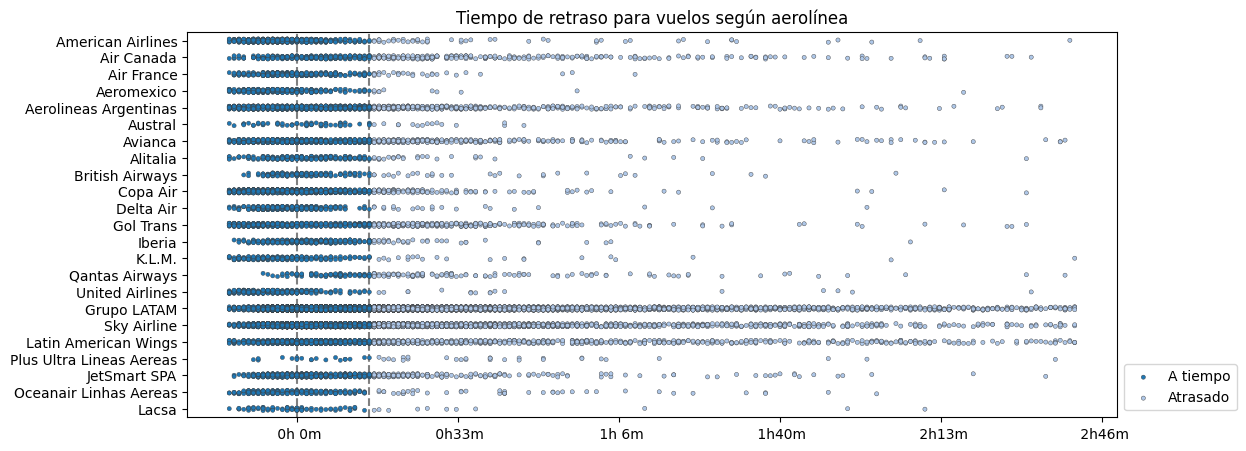

In [19]:
fig = plt.figure(figsize=(12,5))
ax = sns.stripplot(y="OPERA", x="dif_min", size = 3, hue="atraso_15", palette="tab20",
                    data=df, linewidth = 0.3,  jitter=True, legend=False)
ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax.get_xticks()/60])
plt.axvline(x = 0*60, linestyle='--', color = 'grey')
plt.axvline(x = 15*60, linestyle='--', color = 'grey')
plt.legend(labels=['A tiempo', 'Atrasado'],
            loc='lower left', bbox_to_anchor=(1, 0))
plt.title('Tiempo de retraso para vuelos según aerolínea')
ax.yaxis.label.set_visible(False)
ax.xaxis.label.set_visible(False)
plt.show()

### Por mes del año

In [20]:
df_aux = pd.pivot_table(df, values= "atraso_15", index=['MES'], aggfunc=('sum','count')).T
determinador_ratios(df_aux)

MES,1,2,3,4,5,6,7,8,9,10,11,12
Atrasos,978.00,843.00,629.00,584.00,824.00,851.00,1758.00,995.00,967.00,1363.00,1197.00,1615.00
Tasa Atrasos,0.16,0.15,0.11,0.12,0.16,0.17,0.29,0.17,0.17,0.23,0.20,0.25
Total Vuelos,6107.00,5561.00,5479.00,5018.00,5234.00,4979.00,5991.00,5742.00,5609.00,6031.00,6078.00,6356.00


### Por día de la semana

In [21]:
df_aux = pd.pivot_table(df, values= "atraso_15", index=['DIANOM'], aggfunc=('sum','count')).T
determinador_ratios(df_aux)

DIANOM,Domingo,Jueves,Lunes,Martes,Miercoles,Sabado,Viernes
Atrasos,1576.00,2043.00,2046.00,1633.00,1660.00,1363.00,2283.00
Tasa Atrasos,0.16,0.20,0.20,0.17,0.17,0.16,0.22
Total Vuelos,9793.00,10242.00,10128.00,9661.00,9720.00,8351.00,10290.00


### Por temporada (baja/alta)

In [22]:
df_aux = pd.pivot_table(df, values= "atraso_15", index=['temporada_alta'], aggfunc=('sum','count')).T
determinador_ratios(df_aux)

temporada_alta,0,1
Atrasos,8134.00,4470.00
Tasa Atrasos,0.18,0.20
Total Vuelos,45425.00,22760.00


### Por tipo de vuelo (internacional/nacional)

In [23]:
df_aux = pd.pivot_table(df, values= "atraso_15", index=['TIPOVUELO'], aggfunc=('sum','count')).T
determinador_ratios(df_aux)

TIPOVUELO,I,N
Atrasos,7044.00,5560.00
Tasa Atrasos,0.23,0.15
Total Vuelos,31228.00,36957.00


De las tablas anteriores podemos observar algunas conclusiones preliminares:
*  Hay una gran variabilidad en la tasa de atraso según el destino, en algunos casos superior al 50%, lo mismo pasa según las aerolíneas. Estos dos fenómenos pueden naturalmente estar relacionados.

*  En general se ve que la tasa de atraso es mayor en la segunda mitad del año y Julio es el mes con mayor tasa de atrasos.

*  Hay una diferencia sustancial entre la tasa de atraso entre vuelos nacionales e internacionales

*  Si bien hay cambios, no se observa una diferencia tan notoria según el día de la semana o por temporada alta/baja.

En base a esto, dependiendo del tipo de algoritmo para clasificar se esperaría que las variables que presentan mayor fluctiación en la tasa de atraso tuvieran mayor importancia a la hora de predecir el atraso.

Es importante tener esto presente ya que en casos donde hayan muy pocos datos puede llevar a sobreajustar el modelo. Por ejemplo destinos con 0 o 100% de tasa de atrasos pero con 1 o 3 vuelos.

## 4. Entrenamiento de modelos

Eliminaremos las variables con alta correlación o valores constantes basado en nuestra exploración preliminar de los datos y procedemos a separar la data X del target y.

In [24]:
X = df.drop(columns=["Fecha-I", "Fecha-O", "Ori-O", "Ori-I", "SIGLAORI", 
                     "Vlo-O", "OPERA", "TIPOVUELO", "SIGLADES", "AÑO",
                     "atraso_15", "dif_min"], 
            axis=0)
y = df['atraso_15']

# Separamos en datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=10,)

Haremos un onehot encoding de las variables categóricas nominales para poder usarlas en nuestro modelo.

In [25]:
columnas = X.columns
columnas_numericas = X._get_numeric_data().columns
columnas_categoricas = list(set(columnas) - set(columnas_numericas))

# Haremos un hot encoding para pasar las variables categoricas a numeros dummy
preprocessor = ColumnTransformer([('onehot', OneHotEncoder(), 
                                   columnas_categoricas)],
                    remainder='passthrough')
preprocessor.fit_transform(X)
X_train_onehot = preprocessor.transform(X_train).toarray()
X_test_onehot = preprocessor.transform(X_test).toarray()
columnas_onehot = preprocessor.named_transformers_['onehot'].get_feature_names_out(columnas_categoricas)
columnas_finales = np.concatenate([columnas_numericas, columnas_onehot])
X_train = pd.DataFrame(X_train_onehot, columns=columnas_finales)
X_test = pd.DataFrame(X_test_onehot, columns=columnas_finales)

### Modelo 1: Extreme Gradient Boosting

Ahora definiremos nuestro modelo en un pipeline que se dividirá en 3 partes:

*  Balanceo del dataset usando SMOTEENN, método combinado de under- y over-sampling. Corresponde a generar datos sintéticamente de la clase minoritaria usando SMOTE, en este caso los vuelos atrasados y limpieza de datos usando ENN.

*  Clasificación con XGBoost, que corresponde a gradient boosting. Es un buen modelo para obtener un punto de referencia en una aproximación inicial. Para este modelo usaremos una búsqueda de varias combinaciones de hiperparámetros mediante la métrica average_precision y nos quedaremos con el modelo con mejor rendimiento.

*  Se hará validación cruzada también usando el método kfold.

In [26]:

#Definimos el modelo
xg = XGBClassifier(random_state=100)

#Definimos nuestra grilla de búsqueda de hiperparámetros
param_xg = {}
param_xg['classifier__n_estimators'] = [100, 300, 500]
param_xg['classifier__max_depth'] = [5, 10]
param_xg['classifier__learning_rate'] = [0.01, 0.05]
param_xg['classifier__objective'] = ['binary:logistic']
param_xg['classifier'] = [xg]
params = [param_xg]

#Definimos el pipeline
pipeline = Pipeline(steps = [['smote', SMOTEENN(random_state=100)],
                             ['classifier', xg]])

#Definimos la validación cruzada con 3 splits
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=100)


#Realizamos el grid search con la métrica average precision
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=params,
                           scoring='average_precision',
                           cv=stratified_kfold,
                           n_jobs=-1)

#Entrenamos el modelo
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=100, shuffle=True),
             estimator=Pipeline(steps=[['smote', SMOTEENN(random_state=100)],
                                       ['classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      featu...
                                                       max_leaves=None,
                                                       min_child_weight=None,
                                                       missing=nan,
                                                       monotone_constraints=None,
                                                       n_estimators=300,
                                                       n_jobs=None,
                                                       num_parallel_tree=None,
                                                       predictor=None,
                                                       random_state=100, ...)],
                          'classifier__learning_rate': [0.01, 0.05],
                          'classifier__max_depth': [5, 10],
                          'classifier__n_estimators': [100, 300, 500],
                          'classifier__objective': ['binary:logistic']}],
             scoring='average_precision')

Una vez obtenido nuestro modelo podemos ver el mejor set de hiper parámetros encontrados.

In [27]:
print(grid_search.best_params_)

{'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=100, ...), 'classifier__learning_rate': 0.05, 'classifier__max_depth': 10, 'classifier__n_estimators': 300, 'classifier__objective': 'binary:logistic'}


In [28]:
#Verificamos que no hayan grandes diferencias entre el set de testeo y el de validación
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print(f'Rendimiento Cross-validation: {cv_score}\nRendimiento en Test: {test_score}')

#Guardamos el mejor estimador
estimator_XG = grid_search.best_estimator_
y_pred_XG = estimator_XG.predict(X_test)
y_pred_proba_XG = estimator_XG.predict_proba(X_test)

Rendimiento Cross-validation: 0.3892475342481887
Rendimiento en Test: 0.38299747197301115


### Modelo 2: ADA Boosting
Haremos algo similar al modelo anterior pero esta vez usando ada boosting, ya que es útil para modelos desbalanceados como es este caso.

In [29]:
#Definimos el modelo
DTC = DecisionTreeClassifier(criterion="gini", splitter="best", max_features = "sqrt", 
                               max_depth = 5, random_state = 11)
ABC = AdaBoostClassifier(estimator = DTC, random_state=100)

#Definimos nuestra grilla de búsqueda de hiperparámetros
param_grid_ABC = {
              "classifier__learning_rate" :   [0.1, 0.3, 0.5],
              "classifier__n_estimators": [10, 100, 180]
             }

#Definimos el pipeline
pipeline = Pipeline(steps = [['smote', SMOTEENN(random_state=100)],
                             ['classifier', ABC]])

#Definimos la validación cruzada con 3 splits
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=100)


#Realizamos el grid search con la métrica f1_macro
grid_search_ABC = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid_ABC,
                           scoring='f1_macro',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search_ABC.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=100, shuffle=True),
             estimator=Pipeline(steps=[['smote', SMOTEENN(random_state=100)],
                                       ['classifier',
                                        AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5,
                                                                                            max_features='sqrt',
                                                                                            random_state=11),
                                                           random_state=100)]]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.1, 0.3, 0.5],
                         'classifier__n_estimators': [10, 100, 180]},
             scoring='f1_macro')

In [30]:
print(grid_search_ABC.best_params_)

{'classifier__learning_rate': 0.3, 'classifier__n_estimators': 180}


In [31]:
#Verificamos que no hayan grandes diferencias entre el set de testeo y el de validación
cv_score = grid_search_ABC.best_score_
test_score = grid_search_ABC.score(X_test, y_test)
print(f'Rendimiento Cross-validation: {cv_score}\nRendimiento en Test: {test_score}')

#Guardamos el mejor estimador
estimator_ABC = grid_search_ABC.best_estimator_
y_pred_ABC = estimator_ABC.predict(X_test)
y_pred_proba_ABC = estimator_ABC.predict_proba(X_test)

Rendimiento Cross-validation: 0.6195018287686115
Rendimiento en Test: 0.6217045796718724


## 5. Evaluación de modelos
Para los dos modelos generados veremos algunas métricas como: precision, recall, f1-score para cada clase.
Generaremos también una matriz de confusión para los modelos y curvas ROC.

### Modelo 1: Extreme Gradient Boosting

In [82]:
#Imprimimos el reporte de clasificación
print(classification_report(y_test, y_pred_XG))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85     11116
           1       0.38      0.47      0.42      2521

    accuracy                           0.76     13637
   macro avg       0.63      0.65      0.64     13637
weighted avg       0.78      0.76      0.77     13637



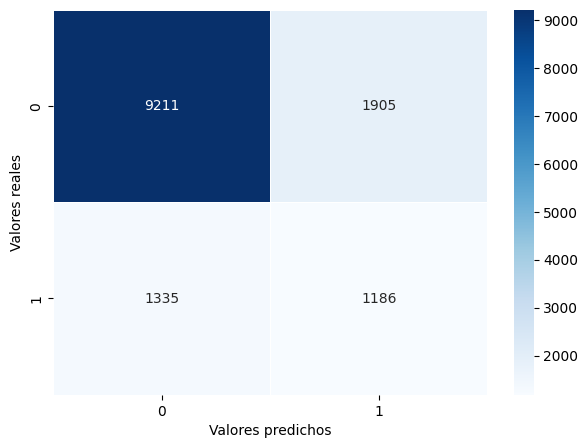

In [83]:
#Calculamos la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_XG)

#Graficamos mediante un heatmap
fig = plt.figure(figsize=(7,5))
ax = sns.heatmap(conf_matrix, annot=True, fmt='g', cmap="Blues", linewidths=0.5)
ax.set_xlabel('Valores predichos')
ax.set_ylabel('Valores reales')
plt.show()

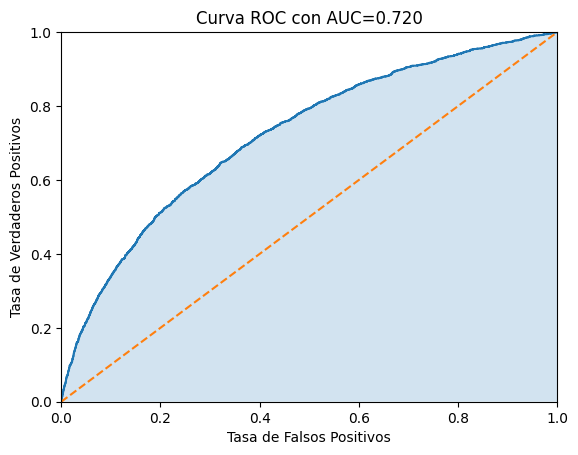

In [84]:
#Calculamos las tasas de verdadero positivo y falso positivo
fpr, tpr, umbral = roc_curve(y_test, y_pred_proba_XG[::,1])

#Calculamos el área bajo la curva ROC
area_curva = auc(fpr, tpr)

#Graficamos la curva ROC
plt.title(f'Curva ROC con AUC={area_curva:.3f}')
plt.plot(fpr, tpr)
plt.fill_between(fpr,tpr,alpha= 0.2)
plt.plot([0, 1], [0, 1],'--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Tasa de Verdaderos Positivos')
plt.xlabel('Tasa de Falsos Positivos')
plt.show()

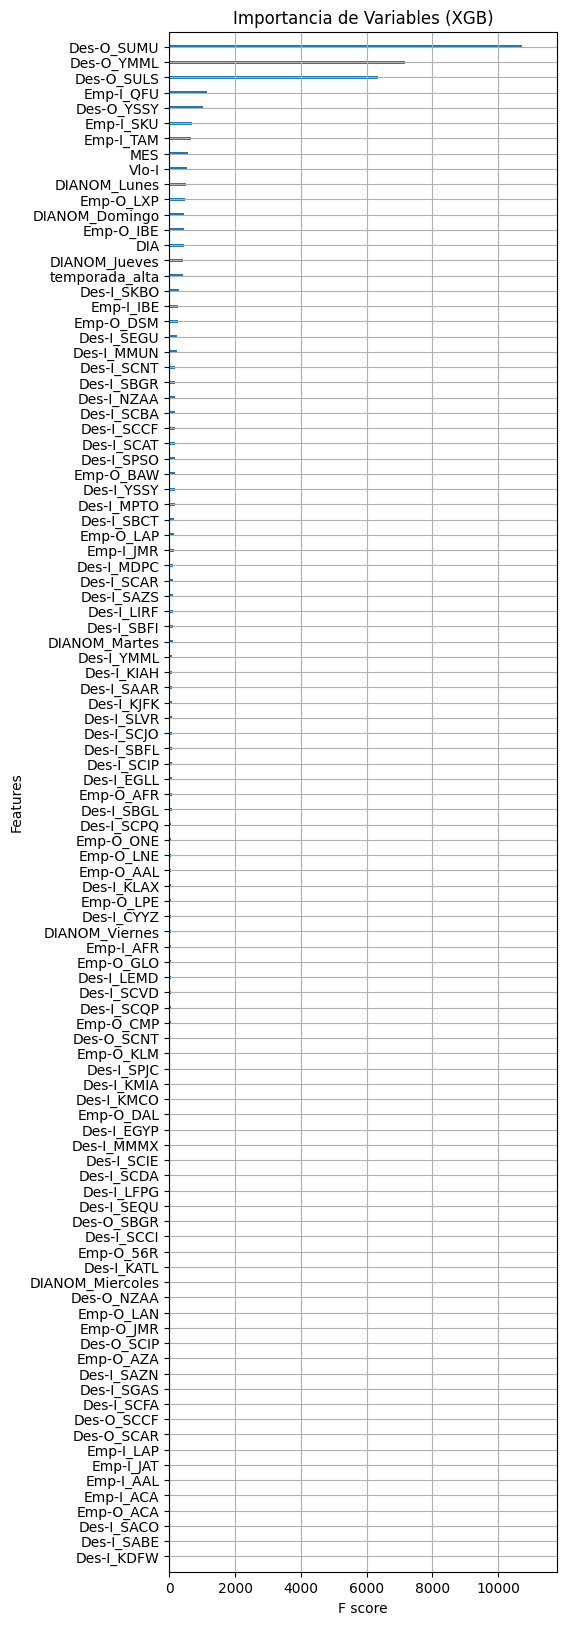

In [85]:
#Ahora graficamos la importancia de las variables
from xgboost import plot_importance
importancias = estimator_XG.named_steps["classifier"]
ax = plot_importance(importancias, show_values=False, title='Importancia de Variables (XGB)')
fig = ax.figure
fig.set_size_inches(5, 20)

### Modelo 2: ADA Boosting

In [86]:
#Imprimimos el reporte de clasificación
print(classification_report(y_test, y_pred_ABC))

              precision    recall  f1-score   support

           0       0.86      0.83      0.85     11116
           1       0.37      0.42      0.39      2521

    accuracy                           0.76     13637
   macro avg       0.62      0.63      0.62     13637
weighted avg       0.77      0.76      0.77     13637



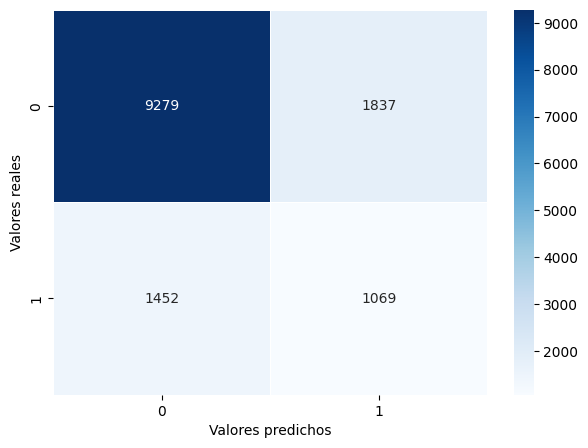

In [87]:
#Calculamos la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_ABC)

#Graficamos mediante un heatmap
fig = plt.figure(figsize=(7,5))
ax = sns.heatmap(conf_matrix, annot=True, fmt='g', cmap="Blues", linewidths=0.5)
ax.set_xlabel('Valores predichos')
ax.set_ylabel('Valores reales')
plt.show()

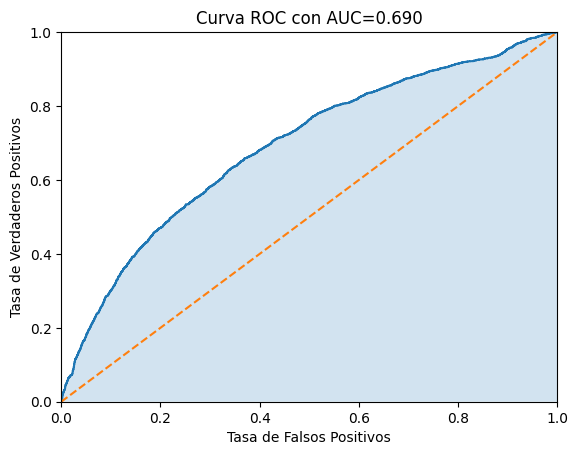

In [88]:
#Calculamos las tasas de verdadero positivo y falso positivo
fpr, tpr, umbral = roc_curve(y_test, y_pred_proba_ABC[::,1])

#Calculamos el área bajo la curva ROC
area_curva = auc(fpr, tpr)

#Graficamos la curva ROC
plt.title(f'Curva ROC con AUC={area_curva:.3f}')
plt.plot(fpr, tpr)
plt.fill_between(fpr,tpr,alpha= 0.2)
plt.plot([0, 1], [0, 1],'--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Tasa de Verdaderos Positivos')
plt.xlabel('Tasa de Falsos Positivos')
plt.show()

En este caso solo graficaremos las primeras 20 variables más importantes

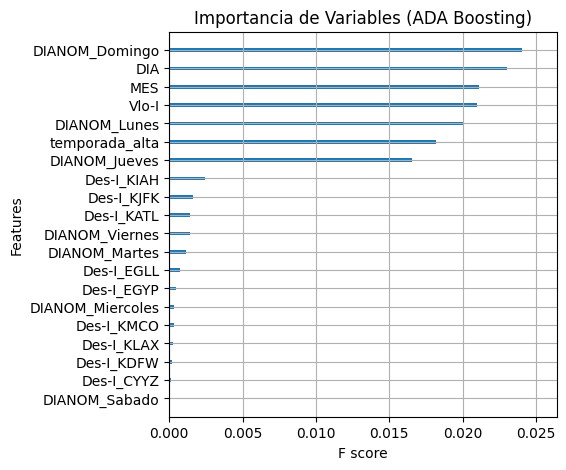

In [89]:
#Ahora graficamos la importancia de las variables
importances=estimator_ABC.named_steps["classifier"].feature_importances_[0:20]
features=columnas_finales[0:20]

importancia = {}
for A, B in zip(features, importances):
    importancia[A] = B

ax = plot_importance(importancia, show_values=False, title='Importancia de Variables (ADA Boosting)')
fig = ax.figure
fig.set_size_inches(5, 5)



### Comentarios acerca de los resultados obtenidos

Acá se detalla un resumen de las métricas obtenidas:

*  En general el rendimiento de los dos modelos es bastante similar, no se logra apreciar una diferencia notoria.
*  Las métricas de precision, recall y f1-score son todas muy similares en promedio con pesos para todo el modelo y un poco más bajas si consideramos un promedio simple.
*  Para los vuelos sin atraso estas mismas métricas son superiores a 0.8, con muy buenos resultados en general.
*  Para los vuelos con atraso son bastante más bajas, con valores cercanos a 0.4, lo que es explicable por el desbalanceo grande de los datos. 
*  En pruebas con y sin SMOTEENN se verificó que en general su uso ayuda a subsanar este desbalanceo aumentando bastante la métrica de recall para la categoría de vuelos atrasados.
*  La matriz de confusión nos muestra que para nuestro set de testeo se tienen ~10000 clasificaciones correctas, ~1300 falsos negativos y ~1800 falsos positivos.
*  El área bajo al curva ROC nos da un valor de ~0.72, lo que significa que nuestro modelo tiene aproximadamente un 72% de probabilidades de discernir entre los vuelos con y sin retraso.

### 5. Comentarios y observaciones finales

Otras observaciones generales:

* **Sobre la elección del modelo**: Los modelos de gradient boosting son muy útiles, y en particular XGBoost es comúnmente usado como primera aproximación por su generalidad, obteniendo buenos rendimientos para data que tenga relaciones fuertemente lineares o no-lineales como es el caso en este dataset. La principal desventaja es que es más costoso computacionalmente que otros modelos con similares rendimientos como RandomForest, pero en este caso el dataset no es tan grande como para llegar a ser un problema y los tiempos de cómputo son prudentes.
También se usó un modelo de ADA Boosting, ya que por lo general tiene buen rendimiento en problemas de clasificación desbalanceados, y éste obtuvo métricas muy similares al primer modelo.

* **Sobre la performance**: En general los resultados obtenidos no son particularmente ideales con accuracy ligeramente mayor al 70%. Sin embargo, sí son totalmente aceptables para un modelo de clasificación entendiendo que la data es real, multi paramétrica y existen algunas dificultades como el desbalanceo de las clases y de algunas variables en general como las aerolineas o los destinos.

* **Sobre las métricas usadas**: Se utilizaron en general tres métodos para evaluar el modelo: métricas de precisión, matriz de confusión y curva ROC. Las métricas de precisión son precision, recall, f1-score y accuracy que son las más comunes de usar al momento de evaluar un algoritmo de clasificación porque nos permiten ver su rendimiento en la predicción para cada clase. Por otra parte, la matriz de confusión también muy usada en algoritmos de clasificación supervisados ayuda a ver visualmente en qué está fallando el algoritmo, en este caso hay más o menos la misma cantidad de falsos negativos que positivos. Y finalmente, la curva ROC ayuda a tener una idea general de como el algoritmo se comporta al discernir entre dos clases.

* **Sobre la importancia de las variables**: Las variables que vemos destacar por sobre otras en importancia son las aerolíneas, algunas en particular parecen ser mucho más indicadoras de retraso que otras. Días de la semana como el domingo, lunes o jueves parecen tener una importancia relativa en la predicción del retraso. Finalmente algunos destinos son también factores importantes. En este sentido variables como OPERA, DIANOM y TIPOVUELO son de importancia así como todas las que estén áltamente correlacionadas con ellas. Debido al uso de onehot encoding las variables categóricas se separan en distintas features independientes, lo que hace más difícil la interpretación de sus importancias, pero esto aumenta el rendimiento del modelo. 

* **Sobre las posibles mejoras**: Principalmente sería de mucha utilidad poder incorporar factores internos o externos a este dataset que pudieran tener influencia en la velocidad de despegue. Factores internos de la gestión del aeropuerto por ejemplo, como alguna métrica relacionada con el manejo de los equipajes o gestión de las pistas de aterrizaje, entre otros. Por otra parte incluir factores externos por ejemplo meteorológicos como la lluvia, velocidad del viento, presencia de neblina, entre otros. Los dos primeros pueden ser obtenidos de manera relativamente fácil como se muestra en el siguiente ejemplo y podrían ser incorporados en otra iteración del modelo.

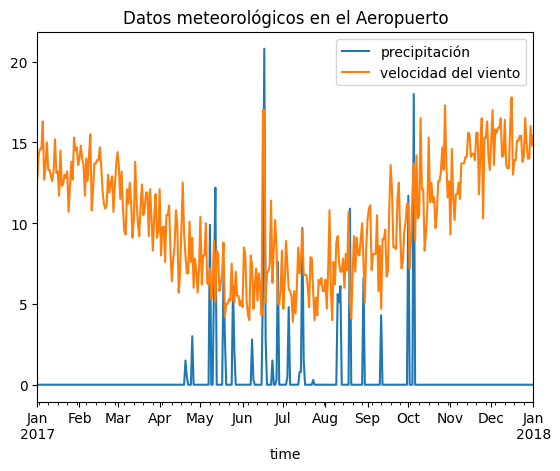

In [90]:
# Ejemplo para obtener datos historicos meteorológicos en el aeropuerto de Chile
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily

#Intervalo de tiempo
start = datetime(2017, 1, 1)
end = datetime(2018, 1, 1)

#Coordenadas aeropuerto
aeropuerto = Point(-33.391527, -70.791175, 474)

#Obtenemos la data
data = Daily(aeropuerto, start, end)
data = data.fetch()

#Graficamos precipitación y velocidad de viento
data.fillna(method="ffill", inplace=True)
data.fillna(0, inplace=True)
data.plot(y=['prcp', 'wspd'])
plt.legend(labels=['precipitación','velocidad del viento'])
plt.title('Datos meteorológicos en el Aeropuerto')
plt.show()